# Import requirements

In [ ]:
!pip install tensorflow_decision_forests
!pip install wurlitzer
!pip install scikit-learn
!pip install matplotlib
!pip install pycm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.8/599.8 kB 6.1 MB/s eta 0:00:00


In [ ]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from pycm import ConfusionMatrix

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

print("Found TensorFlow Decision Forests v" + tfdf.__version__)


Found TensorFlow Decision Forests v1.8.1


# Import and preprocess dataframe

In [ ]:
full_df = pd.read_csv("./data.csv")
full_df.head()


,Address,Flag,Avg_min_between_received_tnx,Avg_min_between_sent_tnx,Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Average_of_Unique_Received_From_Addresses,Average_of_Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,total_transactions_including_tnx_to_create_contract,total_Ether_sent,total_ether_received,total_ether_balance
0,0x000000000532b45f47779fce440748893b257865,1,7.973236e+07,11971.000000,3,20,0,20,3,0.000410,14.331000,5.856601,39.041473,39.044000,39.043158,23,117.129473,117.132025,0.002551
1,0x00000000072d54638c2c2a3da3f715360269eea1,1,5.434648e+07,1281.695652,23,30,0,28,17,0.004312,208.090009,7.173130,0.000000,82.000000,9.389806,53,215.965533,215.193910,-0.771623
2,0x0000000009324b6434d7766af41908e4c49ee1d7,1,1.771695e+08,4494.500000,6,9,0,9,3,0.010000,100.000000,18.246100,15.194834,39.540900,27.368174,15,164.209043,164.214902,0.005859
3,0x0000000086c5d614bec59dfd2c9b88f7cb57f23c,1,3.213748e+08,0.000000,1,5,0,5,1,5.000000,24.178631,10.100583,60.502305,60.502305,60.502305,6,60.502305,50.502914,-9.999391
4,0x00000000bf02300fd6251627aa3db8933a0eee83,1,7.971622e+07,12812.750000,4,20,0,17,2,0.002290,21.000000,4.088321,13.182630,41.477000,25.440253,24,101.761014,81.766424,-19.994590


In [ ]:
df = full_df.drop('Address', axis=1)
df = df.rename(columns={'max_value_received ': 'max_value_received'})
test_indices = np.random.rand(len(df)) < 0.3
train_df, test_df = df[~test_indices], df[test_indices]
train_df_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label='Flag')
test_df_tf = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label='Flag')

# RandomForest model

Note: Data preprocessing and normalization is automatically done by Keras model

In [ ]:
rf_model = tfdf.keras.RandomForestModel()
rf_model.compile(metrics=['accuracy'])
with sys_pipes():
    rf_model.fit(x=train_df_tf)


Use /tmp/tmpd7drdze5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:12.294945. Found 14272 examples.
Training model...


[INFO 23-12-30 20:45:03.0967 UTC kernel.cc:1233] Loading model from path /tmp/tmpd7drdze5/model/ with prefix 11187d2103e940ac
[INFO 23-12-30 20:45:04.0979 UTC decision_forest.cc:660] Model loaded with 300 root(s), 241872 node(s), and 17 input feature(s).
[INFO 23-12-30 20:45:04.0990 UTC abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 23-12-30 20:45:04.0991 UTC kernel.cc:1061] Use fast generic engine


Model trained in 0:00:21.096547
Compiling model...
Model compiled.


In [ ]:
evaluation = rf_model.evaluate(test_df_tf, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

7/7 [==============================] - 1s 35ms/step - loss: 0.0000e+00 - accuracy: 0.9058

loss: 0.0000
accuracy: 0.9058


# KFold Cross Validation

In [ ]:
rf_model = tfdf.keras.RandomForestModel()
rf_model.compile(metrics=['accuracy'])

RANDOM_STATE = 23
kf = KFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)
best_acc = -np.inf
worst_acc = np.inf
best_cm = None
worst_cm = None
accs = []
for train_index, test_index in kf.split(df):
    train_df, test_df = df.iloc[train_index], df.iloc[test_index]
    train_df_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label='Flag')
    test_y = test_df['Flag']
    test_x = test_df.drop('Flag', axis=1)
    test_x_tf = tfdf.keras.pd_dataframe_to_tf_dataset(test_x)
    rf_model.fit(x=train_df_tf)
    test_predicted_probs = rf_model.predict(test_x_tf)
    test_predicted_flags = np.array([1 if prob[0] > 0.5 else 0 for prob in test_predicted_probs])
    cm = ConfusionMatrix(actual_vector = test_y.values, predict_vector = test_predicted_flags)
    cm.relabel({1: "Fraud", 0:"Non-Fraud"})
    accs.append(cm.Overall_ACC)
    if cm.Overall_ACC > best_acc:
        best_acc = cm.Overall_ACC
        best_cm = cm
    if cm.Overall_ACC < worst_acc:
        worst_acc = cm.Overall_ACC
        worst_cm = cm


Use /tmp/tmpmi1h8q3u as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.582242. Found 18271 examples.
Training model...
Model trained in 0:00:18.564954
Compiling model...
Model compiled.
3/3 [==============================] - 0s 24ms/step
Reading training dataset...
Training dataset read in 0:00:00.221210. Found 18271 examples.
Training model...
Model trained in 0:00:17.504019
Compiling model...
Model compiled.


3/3 [==============================] - 0s 24ms/step
Reading training dataset...
Training dataset read in 0:00:00.258708. Found 18272 examples.
Training model...
Model trained in 0:00:17.973440
Compiling model...


Model compiled.
3/3 [==============================] - 0s 23ms/step
Reading training dataset...
Training dataset read in 0:00:00.208258. Found 18272 examples.
Training model...
Model trained in 0:00:17.480959
Compiling model...
Model compiled.
3/3 [==============================] - 0s 23ms/step
Reading training dataset...
Training dataset read in 0:00:00.217980. Found 18272 examples.
Training model...
Model trained in 0:00:19.594656
Compiling model...
Model compiled.
3/3 [==============================] - 0s 24ms/step
Reading training dataset...
Training dataset read in 0:00:00.222660. Found 18272 examples.
Training model...
Model trained in 0:00:17.444829
Compiling model...
Model compiled.
3/3 [==============================] - 0s 22ms/step
Reading training dataset...
Training dataset read in 0:00:00.223054. Found 18272 examples.
Training model...
Model trained in 0:00:24.772522
Compiling model...
Model compiled.
3/3 [==============================] - 0s 22ms/step
Reading training dat

Mean accuracy: 0.91



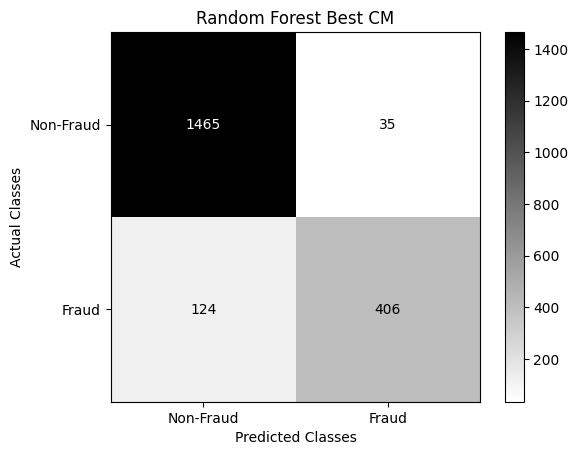

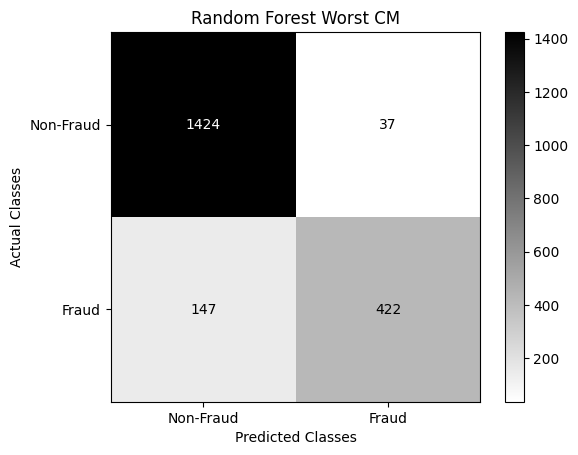

In [ ]:
mean_acc = np.mean(accs).round(2)
print("Mean accuracy: {}\n".format(mean_acc))
best_cm.plot(title="Random Forest Best CM", number_label=True)
worst_cm.plot(title="Random Forest Worst CM", number_label=True)
plt.show()


Note: Data is unbalanced. There are more non-fraud address than fraud ones.

# Final training and model export

In [ ]:
train_df_tf = tfdf.keras.pd_dataframe_to_tf_dataset(df, label='Flag')
with sys_pipes():
    rf_model.fit(x=train_df_tf)

Reading training dataset...
Training dataset read in 0:00:00.238617. Found 20302 examples.
Training model...


[INFO 23-12-30 20:49:30.6163 UTC kernel.cc:1233] Loading model from path /tmp/tmpmi1h8q3u/model/ with prefix 153a7e9e4741477d
[INFO 23-12-30 20:49:31.3294 UTC decision_forest.cc:660] Model loaded with 300 root(s), 315256 node(s), and 17 input feature(s).
[INFO 23-12-30 20:49:31.3294 UTC abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 23-12-30 20:49:31.3295 UTC kernel.cc:1061] Use fast generic engine


Model trained in 0:00:22.008684
Compiling model...
Model compiled.


In [ ]:
!rm -rf ./models
!mkdir -p models
version = 1
path = f"models/{version}/"
rf_model.save(filepath=path, save_format='tf')

In [ ]:
full_df.sample(n=1).iloc[0].to_dict()

{'Address': '0xa25d01f9661e6b9604adf7986ca733a844d6e5f2',
 'Flag': 0,
 'Avg_min_between_received_tnx': 8050.08,
 'Avg_min_between_sent_tnx': 6574.78,
 'Sent_tnx': 47,
 'Received_Tnx': 21,
 'Number_of_Created_Contracts': 0,
 'Average_of_Unique_Received_From_Addresses': 12,
 'Average_of_Unique_Sent_To_Addresses': 25,
 'min_value_received': 0.0699,
 'max_value_received ': 7.35,
 'avg_val_received': 1.869039,
 'min_val_sent': 0.0,
 'max_val_sent': 10.5,
 'avg_val_sent': 0.832368,
 'total_transactions_including_tnx_to_create_contract': 68,
 'total_Ether_sent': 39.1213,
 'total_ether_received': 39.2498154,
 'total_ether_balance': 0.1285154}

In [ ]:
a = df.sample(n=1)
a

,Flag,Avg_min_between_received_tnx,Avg_min_between_sent_tnx,Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Average_of_Unique_Received_From_Addresses,Average_of_Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,total_transactions_including_tnx_to_create_contract,total_Ether_sent,total_ether_received,total_ether_balance
865,1,192606630.6,0.0,1,8,0,8,1,0.045,2.574003,1.146115,9.168058,9.168058,9.168058,9,9.168058,9.168919,0.000861


In [ ]:
a = a.drop('Flag', axis=1)

In [ ]:
a.iloc[0].to_dict()

{'Avg_min_between_received_tnx': 192606630.6,
 'Avg_min_between_sent_tnx': 0.0,
 'Sent_tnx': 1.0,
 'Received_Tnx': 8.0,
 'Number_of_Created_Contracts': 0.0,
 'Average_of_Unique_Received_From_Addresses': 8.0,
 'Average_of_Unique_Sent_To_Addresses': 1.0,
 'min_value_received': 0.045,
 'max_value_received': 2.574003,
 'avg_val_received': 1.146115,
 'min_val_sent': 9.168058,
 'max_val_sent': 9.168058,
 'avg_val_sent': 9.168058,
 'total_transactions_including_tnx_to_create_contract': 9.0,
 'total_Ether_sent': 9.16805757,
 'total_ether_received': 9.16891857,
 'total_ether_balance': 0.000861}

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20302 entries, 0 to 20301
Data columns (total 18 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Flag                                                 20302 non-null  int64  
 1   Avg_min_between_received_tnx                         20302 non-null  float64
 2   Avg_min_between_sent_tnx                             20302 non-null  float64
 3   Sent_tnx                                             20302 non-null  int64  
 4   Received_Tnx                                         20302 non-null  int64  
 5   Number_of_Created_Contracts                          20302 non-null  int64  
 6   Average_of_Unique_Received_From_Addresses            20302 non-null  int64  
 7   Average_of_Unique_Sent_To_Addresses                  20302 non-null  int64  
 8   min_value_received                                   20302 non-nul